In [47]:
from keras.models import Sequential
from keras.layers import Reshape, Activation, Convolution2D, Conv2D, Input, ZeroPadding2D, MaxPooling2D, BatchNormalization, Flatten, Dense
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import os

In [48]:
wt_path = 'tiny-yolo-voc.weights'
ann_dir = './VOCdevkit/VOC2007/Annotations/'
img_dir = './VOCdevkit/VOC2007/JPEGImages/'

In [49]:
# execfile('utils.py')
# import utils
# reload(utils)
exec(open("utils.py").read())

In [50]:
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="1"
# %matplotlib inline

LABELS = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', \
          'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse',\
          'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
NORM_H, NORM_W = 416, 416
GRID_H, GRID_W = 13 , 13
BATCH_SIZE = 8
BOX = 5
CLASS = 20
THRESHOLD = 0.2
ANCHORS = '1.08,1.19,  3.42,4.41,  6.63,11.38,  9.42,5.11,  16.62,10.52'
ANCHORS = [float(ANCHORS.strip()) for ANCHORS in ANCHORS.split(',')]
SCALE_NOOB, SCALE_CONF, SCALE_COOR, SCALE_PROB = 1.0, 5.0, 1.0, 1.0
weight_reader = WeightReader(wt_path)

In [35]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5824749297400989478
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 262930432
locality {
  bus_id: 1
}
incarnation: 9080171809429477848
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0"
]


In [40]:
all_img = parse_annotation(ann_dir)

In [10]:
all_img [:10]

[{'filename': '001952.jpg',
  'height': 397,
  'object': [{'name': 'bird',
    'xmax': 475,
    'xmin': 26,
    'ymax': 372,
    'ymin': 26}],
  'width': 500},
 {'filename': '004463.jpg',
  'height': 324,
  'object': [{'name': 'motorbike',
    'xmax': 395,
    'xmin': 99,
    'ymax': 308,
    'ymin': 124},
   {'name': 'person', 'xmax': 175, 'xmin': 100, 'ymax': 324, 'ymin': 87}],
  'width': 432},
 {'filename': '008900.jpg',
  'height': 375,
  'object': [{'name': 'boat', 'xmax': 500, 'xmin': 1, 'ymax': 124, 'ymin': 42},
   {'name': 'boat', 'xmax': 500, 'xmin': 1, 'ymax': 208, 'ymin': 53},
   {'name': 'person', 'xmax': 92, 'xmin': 3, 'ymax': 301, 'ymin': 193},
   {'name': 'person', 'xmax': 218, 'xmin': 161, 'ymax': 303, 'ymin': 148},
   {'name': 'person', 'xmax': 287, 'xmin': 205, 'ymax': 248, 'ymin': 151},
   {'name': 'person', 'xmax': 412, 'xmin': 353, 'ymax': 255, 'ymin': 110},
   {'name': 'person', 'xmax': 482, 'xmin': 411, 'ymax': 203, 'ymin': 109},
   {'name': 'person', 'xmax': 461

In [51]:
model = Sequential()

# Layer 1
model.add(ZeroPadding2D(padding=(1,1), input_shape=(416,416,3)))
model.add(Convolution2D(16, 3, 3, subsample=(1,1), bias=False))
model.add(BatchNormalization(mode=0))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2 - 5
for i in range(0,4):
    model.add(ZeroPadding2D(padding=(1,1)))
    model.add(Convolution2D(32*(2**i), 3, 3, subsample=(1,1), bias=False))
    model.add(BatchNormalization(mode=0))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 6
model.add(ZeroPadding2D(padding=(1,1)))
model.add(Convolution2D(512, 3, 3, subsample=(1,1), bias=False))
model.add(BatchNormalization(mode=0))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1,1), border_mode='same'))

# Layer 7 - 8
for _ in range(0,2):
    model.add(ZeroPadding2D(padding=(1,1)))
    model.add(Convolution2D(1024, 3, 3, subsample=(1,1), bias=False))
    model.add(BatchNormalization(mode=0))
    model.add(LeakyReLU(alpha=0.1))

# Layer 9
model.add(Convolution2D(125, 1, 1, subsample=(1,1)))
model.add(Activation('linear'))
model.add(Reshape((13, 13, 5, 25)))

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), strides=(1, 1), use_bias=False)`
  """
/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization()`
  
/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), strides=(1, 1), use_bias=False)`
  del sys.path[0]
/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization()`
  
/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), strides=(1, 1), use_bias=False)`
  del sys.path[0]
/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call t

In [42]:
weight_reader.reset()

for i in range(len(model.layers)):
    if 'conv' in model.layers[i].name:
        if 'batch' in model.layers[i+1].name:
            norm_layer = model.layers[i+1]
            size = np.prod(norm_layer.get_weights()[0].shape)
            
            beta  = weight_reader.read_bytes(size)
            gamma = weight_reader.read_bytes(size)
            mean  = weight_reader.read_bytes(size)
            var   = weight_reader.read_bytes(size)
            
            weights = norm_layer.set_weights([gamma, beta, mean, var])
            
        conv_layer = model.layers[i]
        if len(conv_layer.get_weights()) > 1:
            bias   = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
            kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
            kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
            kernel = kernel.transpose([2,3,1,0])
            conv_layer.set_weights([kernel, bias])
        else:
            kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
            kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
            kernel = kernel.transpose([2,3,1,0])
            conv_layer.set_weights([kernel])

In [43]:
def custom_loss(y_true, y_pred):
    ### Adjust prediction
    # adjust x and y      
    pred_box_xy = tf.sigmoid(y_pred[:,:,:,:,:2])
    
    # adjust w and h
    pred_box_wh = tf.exp(y_pred[:,:,:,:,2:4]) * np.reshape(ANCHORS, [1,1,1,BOX,2])
    pred_box_wh = tf.sqrt(pred_box_wh / np.reshape([float(GRID_W), float(GRID_H)], [1,1,1,1,2]))
    
    # adjust confidence
    pred_box_conf = tf.expand_dims(tf.sigmoid(y_pred[:, :, :, :, 4]), -1)
    
    # adjust probability
    pred_box_prob = tf.nn.softmax(y_pred[:, :, :, :, 5:])
    
    y_pred = tf.concat([pred_box_xy, pred_box_wh, pred_box_conf, pred_box_prob], 4)
    
    ### Adjust ground truth
    # adjust x and y
    center_xy = .5*(y_true[:,:,:,:,0:2] + y_true[:,:,:,:,2:4])
    center_xy = center_xy / np.reshape([(float(NORM_W)/GRID_W), (float(NORM_H)/GRID_H)], [1,1,1,1,2])
    true_box_xy = center_xy - tf.floor(center_xy)
    
    # adjust w and h
    true_box_wh = (y_true[:,:,:,:,2:4] - y_true[:,:,:,:,0:2])
    true_box_wh = tf.sqrt(true_box_wh / np.reshape([float(NORM_W), float(NORM_H)], [1,1,1,1,2]))
    
    # adjust confidence
    pred_tem_wh = tf.pow(pred_box_wh, 2) * np.reshape([GRID_W, GRID_H], [1,1,1,1,2])
    pred_box_area = pred_tem_wh[:,:,:,:,0] * pred_tem_wh[:,:,:,:,1]
    pred_box_ul = pred_box_xy - 0.5 * pred_tem_wh
    pred_box_bd = pred_box_xy + 0.5 * pred_tem_wh
    
    true_tem_wh = tf.pow(true_box_wh, 2) * np.reshape([GRID_W, GRID_H], [1,1,1,1,2])
    true_box_area = true_tem_wh[:,:,:,:,0] * true_tem_wh[:,:,:,:,1]
    true_box_ul = true_box_xy - 0.5 * true_tem_wh
    true_box_bd = true_box_xy + 0.5 * true_tem_wh
    
    intersect_ul = tf.maximum(pred_box_ul, true_box_ul) 
    intersect_br = tf.minimum(pred_box_bd, true_box_bd)
    intersect_wh = intersect_br - intersect_ul
    intersect_wh = tf.maximum(intersect_wh, 0.0)
    intersect_area = intersect_wh[:,:,:,:,0] * intersect_wh[:,:,:,:,1]
    
    iou = tf.truediv(intersect_area, true_box_area + pred_box_area - intersect_area)
    best_box = tf.equal(iou, tf.reduce_max(iou, [3], True)) 
    best_box = tf.to_float(best_box)
    true_box_conf = tf.expand_dims(best_box * y_true[:,:,:,:,4], -1)
    
    # adjust confidence
    true_box_prob = y_true[:,:,:,:,5:]
    
    y_true = tf.concat([true_box_xy, true_box_wh, true_box_conf, true_box_prob], 4)
    #y_true = tf.Print(y_true, [true_box_wh], message='DEBUGGGGGGGGGG ', summarize=30000)    
    
    ### Compute the weights
    weight_coor = tf.concat(4 * [true_box_conf], 4)
    weight_coor = SCALE_COOR * weight_coor
    
    weight_conf = SCALE_NOOB * (1. - true_box_conf) + SCALE_CONF * true_box_conf
    
    weight_prob = tf.concat(CLASS * [true_box_conf], 4) 
    weight_prob = SCALE_PROB * weight_prob 
    
    weight = tf.concat([weight_coor, weight_conf, weight_prob], 4)
    
    ### Finalize the loss
    loss = tf.pow(y_pred - y_true, 2)
    loss = loss * weight
    loss = tf.reshape(loss, [-1, GRID_W*GRID_H*BOX*(4 + 1 + CLASS)])
    loss = tf.reduce_sum(loss, 1)
    loss = .5 * tf.reduce_mean(loss)
    
    return loss

In [44]:
layer = model.layers[-3]
weights = layer.get_weights()
layer.set_weights([np.random.normal(size=weights[0].shape)/(GRID_H*GRID_W), np.random.normal(size=weights[1].shape)/(GRID_H*GRID_W)])

In [45]:
early_stop = EarlyStopping(monitor='loss', min_delta=0.01, patience=5, mode='min', verbose=1)
checkpoint = ModelCheckpoint('weights.hdf5', monitor='loss', verbose=1, save_best_only=True, mode='min', period=1)

model.compile(loss=custom_loss, optimizer='adagrad')


In [16]:
# model.fit_generator(data_gen(all_img, BATCH_SIZE), 
#                     16, 
#                     1, 
#                     verbose=2, 
#                     callbacks=[early_stop, checkpoint], 
#                     max_q_size=3)

# model.fit_generator(data_gen(all_img, BATCH_SIZE), len(all_img),
#                     500, verbose=2, callbacks=[early_stop, checkpoint], max_q_size=3)

# model.fit_generator(data_gen(all_img, BATCH_SIZE), 
#                     200, 
#                     10, 
#                     verbose=2, 
#                     callbacks=[early_stop, checkpoint], 
#                     max_q_size=3)

Epoch 1/10
Epoch 00000: loss improved from inf to 20.24603, saving model to weights.hdf5
78s - loss: 20.2460
Epoch 2/10
Epoch 00001: loss improved from 20.24603 to 9.67090, saving model to weights.hdf5
76s - loss: 9.6709
Epoch 3/10
Epoch 00002: loss improved from 9.67090 to 9.39391, saving model to weights.hdf5
76s - loss: 9.3939
Epoch 4/10
Epoch 00003: loss improved from 9.39391 to 9.23885, saving model to weights.hdf5
35s - loss: 9.2020
Epoch 5/10
Epoch 00004: loss improved from 9.23885 to 8.62812, saving model to weights.hdf5
27s - loss: 8.6281
Epoch 6/10
Epoch 00005: loss did not improve
26s - loss: 9.7161
Epoch 7/10
Epoch 00006: loss did not improve
26s - loss: 9.5130
Epoch 8/10
Epoch 00007: loss did not improve
26s - loss: 9.2717
Epoch 9/10
Epoch 00008: loss did not improve
26s - loss: 9.0979
Epoch 10/10
Epoch 00009: loss did not improve
26s - loss: 8.8566


In [ ]:
model.fit_generator(data_gen(all_img, BATCH_SIZE), len(all_img),
                    50, verbose=2, callbacks=[early_stop, checkpoint], max_q_size=3)

Epoch 1/50
Epoch 00000: loss improved from inf to 8.72159, saving model to weights.hdf5
610s - loss: 8.4889
Epoch 2/50
Epoch 00001: loss improved from 8.72159 to 8.19854, saving model to weights.hdf5
363s - loss: 8.1985
Epoch 3/50
Epoch 00002: loss improved from 8.19854 to 7.76466, saving model to weights.hdf5
363s - loss: 7.7647
Epoch 4/50
Epoch 00003: loss improved from 7.76466 to 7.67039, saving model to weights.hdf5
363s - loss: 7.6704
Epoch 5/50
Epoch 00004: loss improved from 7.67039 to 7.45457, saving model to weights.hdf5


In [52]:
model.load_weights("weights.hdf5")

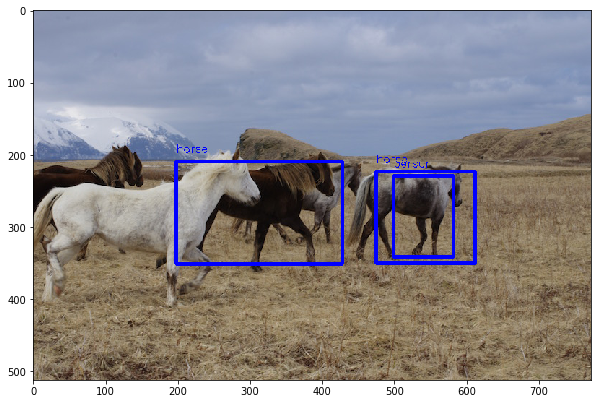

In [54]:
image = cv2.imread('horses.jpg')

plt.figure(figsize=(10,10))

input_image = cv2.resize(image, (416, 416))
input_image = input_image / 255.
input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)

netout = model.predict(input_image)

#print netout
image = interp_netout(image, netout[0])
plt.imshow(image[:,:,::-1]); plt.show()

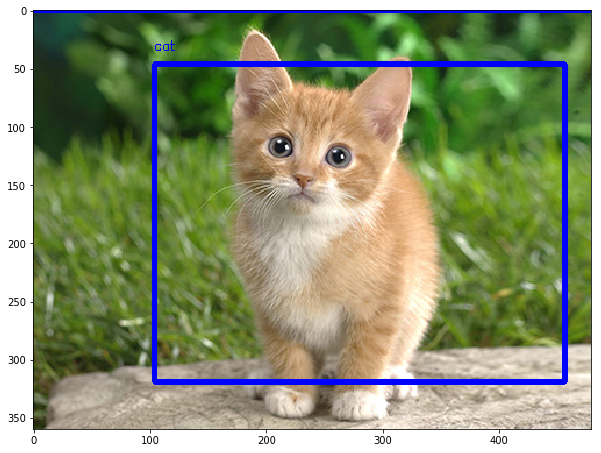

In [55]:
image = cv2.imread('cat.jpg')

plt.figure(figsize=(10,10))

input_image = cv2.resize(image, (416, 416))
input_image = input_image / 255.
input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)

netout = model.predict(input_image)

#print netout
image = interp_netout(image, netout[0])
plt.imshow(image[:,:,::-1]); plt.show()

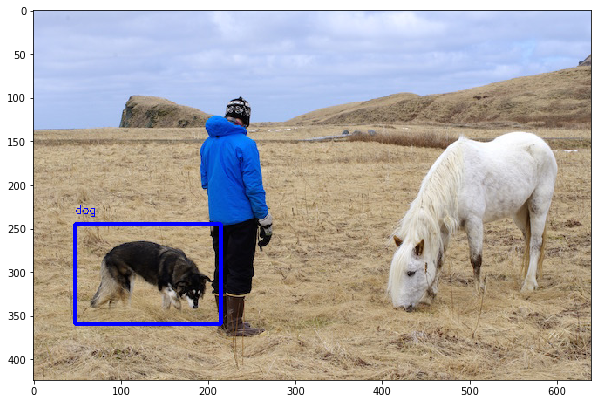

In [57]:
image = cv2.imread('person.jpg')

plt.figure(figsize=(10,10))

input_image = cv2.resize(image, (416, 416))
input_image = input_image / 255.
input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)

netout = model.predict(input_image)

#print netout
image = interp_netout(image, netout[0])
plt.imshow(image[:,:,::-1]); plt.show()